# Random Forests - Heart Failure Dataset
## Holdout
_The random forest is a classification algorithm consisting of many decisions trees. It uses bagging and feature randomness when building each individual tree to try to create an uncorrelated forest of trees whose prediction by committee is more accurate than that of any individual tree._

## Original Dataset

### Random Forests

In [1]:
# Load Libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import ds_functions as ds
from sklearn.model_selection import KFold, cross_val_score

In [2]:
data: pd.DataFrame = pd.read_csv('../../datasets/heart_failure_clinical_records_dataset.csv')
y: np.ndarray = data.pop('DEATH_EVENT').values
X: np.ndarray = data.values
labels = pd.unique(y)
labels = pd.unique(y)
if(labels[0] == 1):
    temp = labels[0]
    labels[0] = labels[1]
    labels[1] = temp

<Figure size 600x450 with 0 Axes>

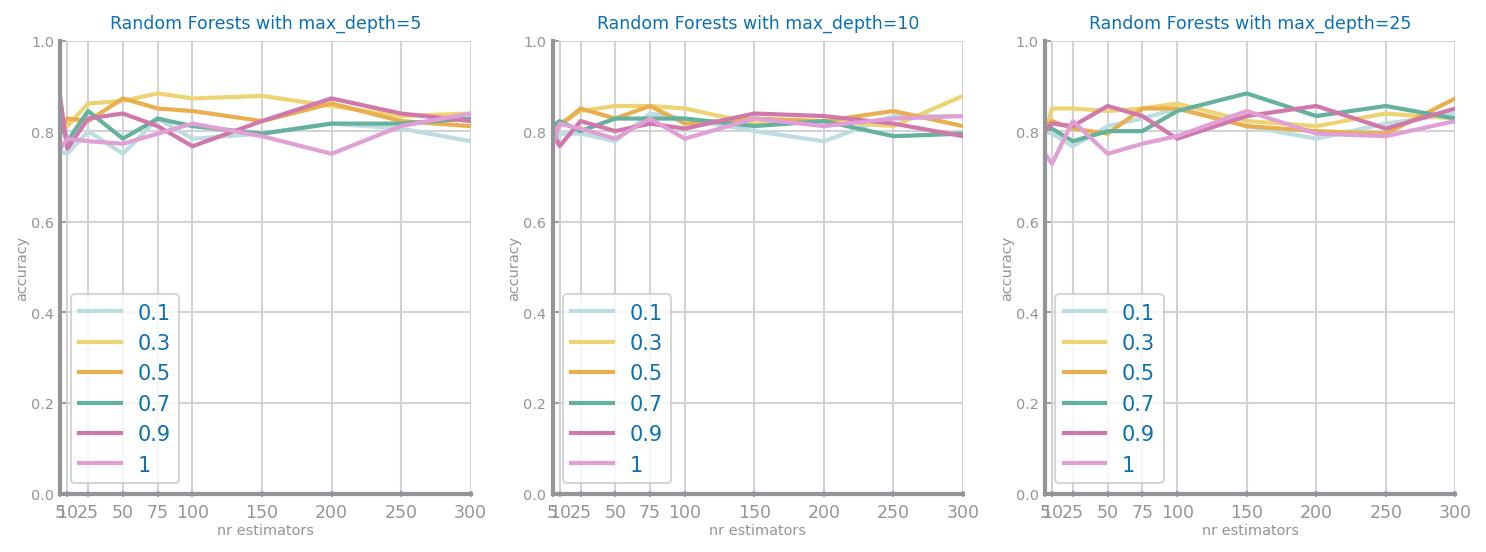

Best results with depth=5, 0.30 features and 75 estimators, with accuracy=0.88


In [3]:
n_estimators = [5, 10, 25, 50, 75, 100, 150, 200, 250, 300]
max_depths = [5, 10, 25]
max_features = [.1, .3, .5, .7, .9, 1]
best_rand_forest = ('', 0, 0)
last_best_rf = 0
best_rf = None
n_holdouts = 2

cols = len(max_depths)
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    for f in max_features:
        yvalues = []
        for n in n_estimators:
            
            total_acc = 0
            
            for h in range(n_holdouts):
                trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

                rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)
                rf.fit(trnX, trnY)
                prdY = rf.predict(tstX)
                total_acc += metrics.accuracy_score(tstY, prdY)

            total_acc /= n_holdouts
            yvalues.append(total_acc)
            if yvalues[-1] > last_best_rf:
                best_rand_forest = (d, f, n)
                last_best_rf = yvalues[-1]
                best_rf = rf
                
        values[f] = yvalues
    ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title='Random Forests with max_depth=%d'%d,
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)

plt.show()
print('Best results with depth=%d, %1.2f features and %d estimators, with accuracy=%1.2f'%(best_rand_forest[0], best_rand_forest[1], best_rand_forest[2], last_best_rf))

### Extremely Randomized Trees

In extremely randomized trees, randomness goes one step further in the way splits are computed. As in random forests, a random subset of candidate features is used, but instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias. Random Forest and Extremely Randomized Trees differ in the sense that the splits of the trees in the Random Forest are deterministic whereas they are random in the case of an Extremely Randomized Trees (to be more accurate, the next split is the best split among random uniform splits in the selected variables for the current tree).

<Figure size 600x450 with 0 Axes>

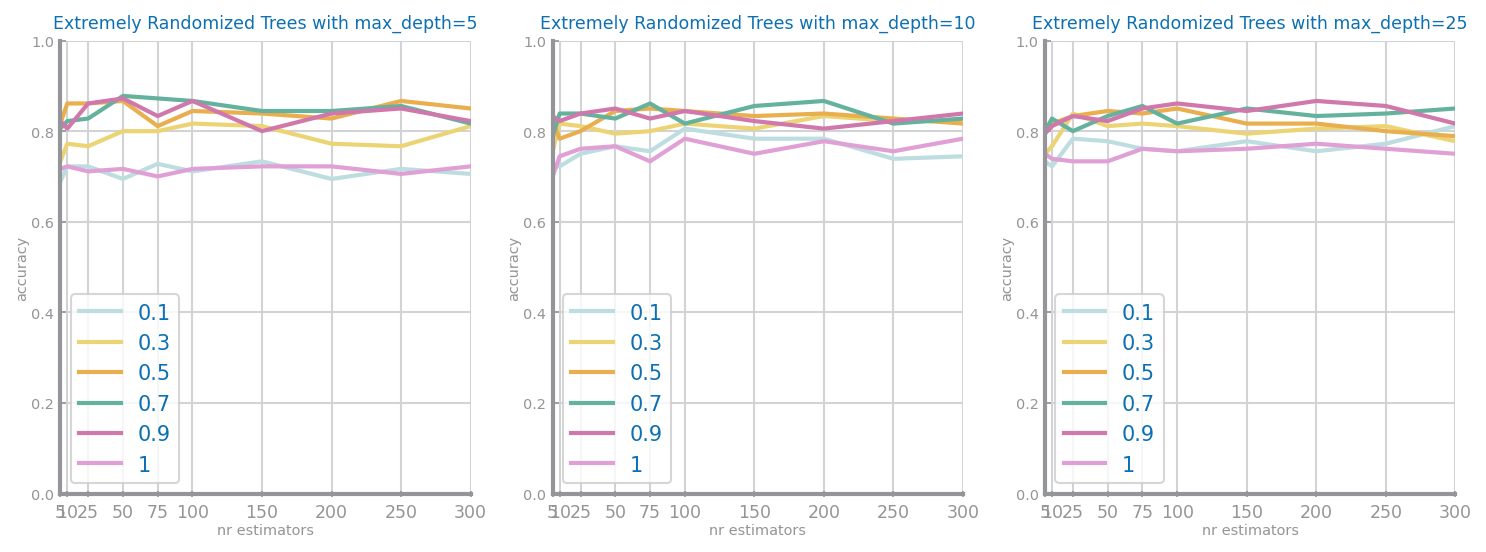

Best results with depth=5, 0.70 features and 50 estimators, with accuracy=0.88


In [4]:
best_extr_tree = ('', 0, 0)
last_best_xt = 0
best_xt = None

cols = len(max_depths)
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    for f in max_features:
        yvalues = []
        for n in n_estimators:
            
            total_acc = 0
            
            for h in range(n_holdouts):
                trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

                rf = ExtraTreesClassifier(n_estimators=n, max_depth=d, max_features=f)
                rf.fit(trnX, trnY)
                prdY = rf.predict(tstX)
                total_acc += metrics.accuracy_score(tstY, prdY)

            total_acc /= n_holdouts
            yvalues.append(total_acc)
            if yvalues[-1] > last_best_xt:
                best_extr_tree = (d, f, n)
                last_best_xt = yvalues[-1]
                best_xt = rf
                
        values[f] = yvalues
    ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title='Extremely Randomized Trees with max_depth=%d'%d,
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)

plt.show()
print('Best results with depth=%d, %1.2f features and %d estimators, with accuracy=%1.2f'%(best_extr_tree[0], best_extr_tree[1], best_extr_tree[2], last_best_xt))

### Comparing Results

In [17]:
# Compute Average Metrics for Best Random Forest vs. Best Extremely Random Trees

acc = [0, 0]
recall = [0, 0]
specificity = [0, 0]
precision = [0, 0]
matrices = np.zeros((2, 2, n_holdouts))

for h in range(n_holdouts):
    trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

    rf = RandomForestClassifier(n_estimators=best_rand_forest[2], max_depth=best_rand_forest[0], max_features=best_rand_forest[1])
    rf.fit(trnX, trnY)
    
    prd_trn = rf.predict(trnX)
    prd_tst = rf.predict(tstX)
    
    cnf_mtx_trn = metrics.confusion_matrix(trnY, prd_trn, labels)
    tn_trn, fp_trn, fn_trn, tp_trn = cnf_mtx_trn.ravel()
    cnf_mtx_tst = metrics.confusion_matrix(tstY, prd_tst, labels)
    matrices[:,:,h] = cnf_mtx_tst
    tn_tst, fp_tst, fn_tst, tp_tst = cnf_mtx_tst.ravel()
    
    acc[0] += (tn_trn + tp_trn) / (tn_trn + tp_trn + fp_trn + fn_trn)
    acc[1] += (tn_tst + tp_tst) / (tn_tst + tp_tst + fp_tst + fn_tst)
    
    recall[0] += tp_trn / (tp_trn + fn_trn)
    recall[1] += tp_tst / (tp_tst + fn_tst)
    
    specificity[0] += tn_trn / (tn_trn + fp_trn)
    specificity[1] += tn_tst / (tn_tst + fp_tst)
    
    precision[0] += tp_trn / (tp_trn + fp_trn)
    precision[1] += tp_tst / (tp_tst + fp_tst)
    

acc = np.divide(acc, n_holdouts)
recall = np.divide(recall, n_holdouts)
specificity = np.divide(specificity, n_holdouts)
precision = np.divide(precision, n_holdouts)
cnf_mtx_rt = np.mean(matrices, axis=2).astype('int64')

evaluation_rt = {'Accuracy': acc,
              'Recall': recall,
              'Specificity': specificity,
              'Precision': precision}

Random Forests:
 {'Accuracy': array([0.94, 0.84]), 'Recall': array([0.86, 0.62]), 'Specificity': array([0.99, 0.95]), 'Precision': array([0.97, 0.86])}

Extremely Random Trees:
 {'Accuracy': array([0.93, 0.82]), 'Recall': array([0.81, 0.53]), 'Specificity': array([0.99, 0.95]), 'Precision': array([0.97, 0.83])}


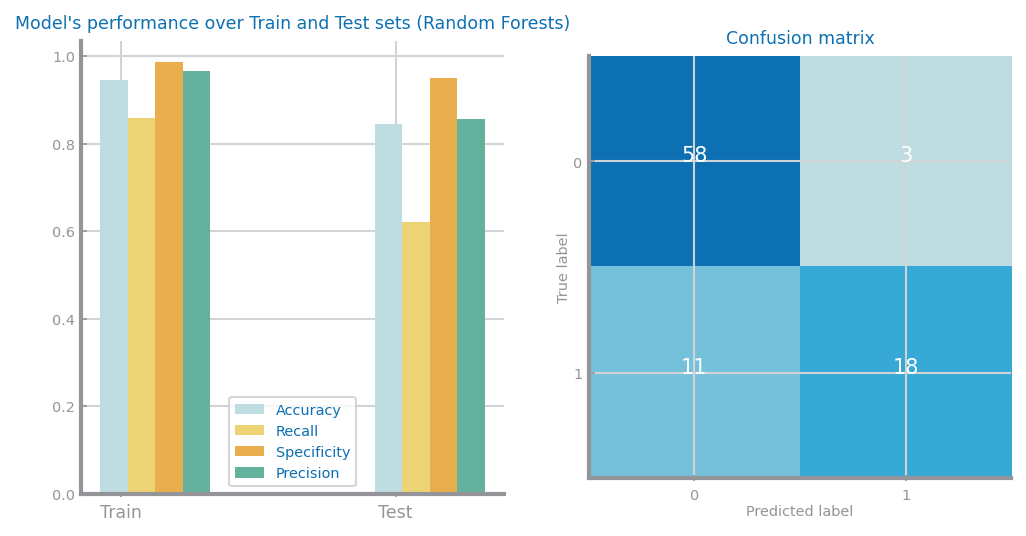

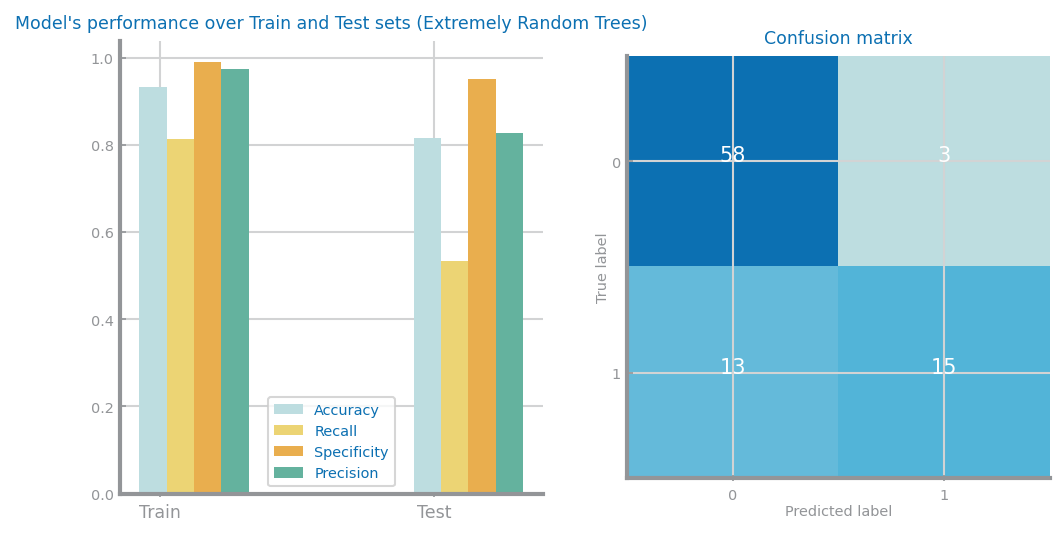

In [23]:
acc = [0, 0]
recall = [0, 0]
specificity = [0, 0]
precision = [0, 0]
matrices = np.zeros((2, 2, n_holdouts))

for h in range(n_holdouts):
    trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

    rf = ExtraTreesClassifier(n_estimators=best_extr_tree[2], max_depth=best_extr_tree[0], max_features=best_extr_tree[1])
    rf.fit(trnX, trnY)
    
    prd_trn = rf.predict(trnX)
    prd_tst = rf.predict(tstX)
    
    cnf_mtx_trn = metrics.confusion_matrix(trnY, prd_trn, labels)
    tn_trn, fp_trn, fn_trn, tp_trn = cnf_mtx_trn.ravel()
    cnf_mtx_tst = metrics.confusion_matrix(tstY, prd_tst, labels)
    matrices[:,:,h] = cnf_mtx_tst
    tn_tst, fp_tst, fn_tst, tp_tst = cnf_mtx_tst.ravel()
    
    acc[0] += (tn_trn + tp_trn) / (tn_trn + tp_trn + fp_trn + fn_trn)
    acc[1] += (tn_tst + tp_tst) / (tn_tst + tp_tst + fp_tst + fn_tst)
    
    recall[0] += tp_trn / (tp_trn + fn_trn)
    recall[1] += tp_tst / (tp_tst + fn_tst)
    
    specificity[0] += tn_trn / (tn_trn + fp_trn)
    specificity[1] += tn_tst / (tn_tst + fp_tst)
    
    precision[0] += tp_trn / (tp_trn + fp_trn)
    precision[1] += tp_tst / (tp_tst + fp_tst)
    

acc = np.divide(acc, n_holdouts)
recall = np.divide(recall, n_holdouts)
specificity = np.divide(specificity, n_holdouts)
precision = np.divide(precision, n_holdouts)
cnf_mtx = np.mean(matrices, axis=2).astype('int64')

evaluation = {'Accuracy': acc,
              'Recall': recall,
              'Specificity': specificity,
              'Precision': precision}

fig, axs = plt.subplots(1, 2, figsize=(2 * ds.HEIGHT, ds.HEIGHT))
ds.multiple_bar_chart(['Train', 'Test'], evaluation_rt, ax=axs[0], title="Model's performance over Train and Test sets (Random Forests)")
ds.plot_confusion_matrix(cnf_mtx_rt, labels, ax=axs[1])

print("Random Forests:\n", evaluation_rt)

fig, axs = plt.subplots(1, 2, figsize=(2 * ds.HEIGHT, ds.HEIGHT))
ds.multiple_bar_chart(['Train', 'Test'], evaluation, ax=axs[0], title="Model's performance over Train and Test sets (Extremely Random Trees)")
ds.plot_confusion_matrix(cnf_mtx, labels, ax=axs[1])

print("\nExtremely Random Trees:\n", evaluation)

<br/>
<br/>
<br/>
<br/>
<br/>

## Scaled Dataset (Standardized)

### Random Forests

In [2]:
data: pd.DataFrame = pd.read_csv('../../datasets/hf_scaled/HF_standardized.csv')
y: np.ndarray = data.pop('DEATH_EVENT').values
X: np.ndarray = data.values
labels = pd.unique(y)
labels = pd.unique(y)
if(labels[0] == 1):
    temp = labels[0]
    labels[0] = labels[1]
    labels[1] = temp

<Figure size 600x450 with 0 Axes>

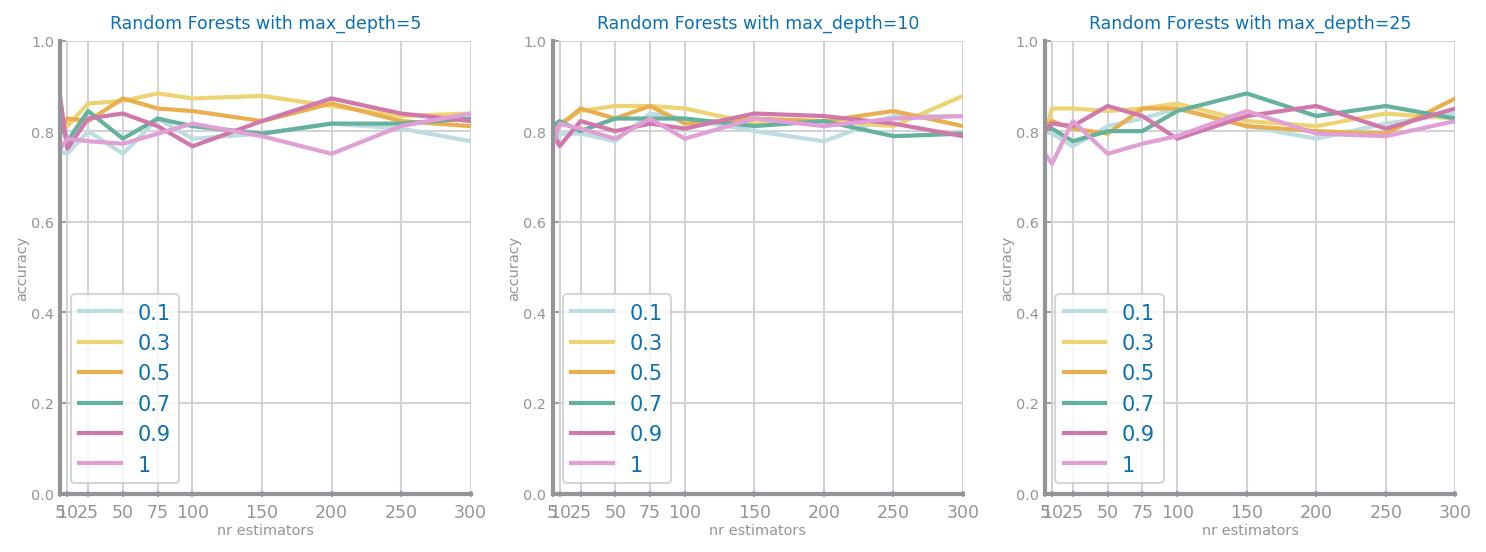

Best results with depth=5, 0.30 features and 75 estimators, with accuracy=0.88


In [3]:
n_estimators = [5, 10, 25, 50, 75, 100, 150, 200, 250, 300]
max_depths = [5, 10, 25]
max_features = [.1, .3, .5, .7, .9, 1]
best_rand_forest = ('', 0, 0)
last_best_rf = 0
best_rf = None
n_holdouts = 2

cols = len(max_depths)
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    for f in max_features:
        yvalues = []
        for n in n_estimators:
            
            total_acc = 0
            
            for h in range(n_holdouts):
                trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

                rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)
                rf.fit(trnX, trnY)
                prdY = rf.predict(tstX)
                total_acc += metrics.accuracy_score(tstY, prdY)

            total_acc /= n_holdouts
            yvalues.append(total_acc)
            if yvalues[-1] > last_best_rf:
                best_rand_forest = (d, f, n)
                last_best_rf = yvalues[-1]
                best_rf = rf
                
        values[f] = yvalues
    ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title='Random Forests with max_depth=%d'%d,
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)

plt.show()
print('Best results with depth=%d, %1.2f features and %d estimators, with accuracy=%1.2f'%(best_rand_forest[0], best_rand_forest[1], best_rand_forest[2], last_best_rf))

### Extremely Randomized Trees

In extremely randomized trees, randomness goes one step further in the way splits are computed. As in random forests, a random subset of candidate features is used, but instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias.

<Figure size 600x450 with 0 Axes>

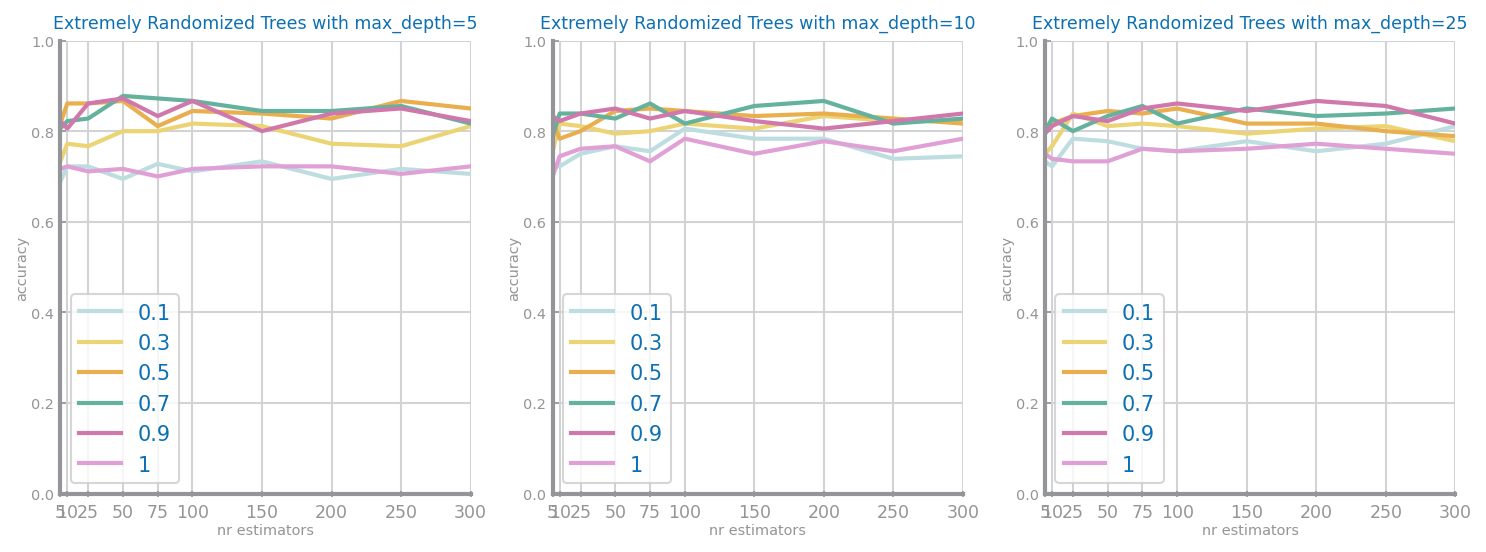

Best results with depth=5, 0.70 features and 50 estimators, with accuracy=0.88


In [4]:
best_extr_tree = ('', 0, 0)
last_best_xt = 0
best_xt = None

cols = len(max_depths)
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    for f in max_features:
        yvalues = []
        for n in n_estimators:
            
            total_acc = 0
            
            for h in range(n_holdouts):
                trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

                rf = ExtraTreesClassifier(n_estimators=n, max_depth=d, max_features=f)
                rf.fit(trnX, trnY)
                prdY = rf.predict(tstX)
                total_acc += metrics.accuracy_score(tstY, prdY)

            total_acc /= n_holdouts
            yvalues.append(total_acc)
            if yvalues[-1] > last_best_xt:
                best_extr_tree = (d, f, n)
                last_best_xt = yvalues[-1]
                best_xt = rf
                
        values[f] = yvalues
    ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title='Extremely Randomized Trees with max_depth=%d'%d,
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)

plt.show()
print('Best results with depth=%d, %1.2f features and %d estimators, with accuracy=%1.2f'%(best_extr_tree[0], best_extr_tree[1], best_extr_tree[2], last_best_xt))

### Comparing Results

In [17]:
# Compute Average Metrics for Best Random Forest vs. Best Extremely Random Trees

acc = [0, 0]
recall = [0, 0]
specificity = [0, 0]
precision = [0, 0]
matrices = np.zeros((2, 2, n_holdouts))

for h in range(n_holdouts):
    trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

    rf = RandomForestClassifier(n_estimators=best_rand_forest[2], max_depth=best_rand_forest[0], max_features=best_rand_forest[1])
    rf.fit(trnX, trnY)
    
    prd_trn = rf.predict(trnX)
    prd_tst = rf.predict(tstX)
    
    cnf_mtx_trn = metrics.confusion_matrix(trnY, prd_trn, labels)
    tn_trn, fp_trn, fn_trn, tp_trn = cnf_mtx_trn.ravel()
    cnf_mtx_tst = metrics.confusion_matrix(tstY, prd_tst, labels)
    matrices[:,:,h] = cnf_mtx_tst
    tn_tst, fp_tst, fn_tst, tp_tst = cnf_mtx_tst.ravel()
    
    acc[0] += (tn_trn + tp_trn) / (tn_trn + tp_trn + fp_trn + fn_trn)
    acc[1] += (tn_tst + tp_tst) / (tn_tst + tp_tst + fp_tst + fn_tst)
    
    recall[0] += tp_trn / (tp_trn + fn_trn)
    recall[1] += tp_tst / (tp_tst + fn_tst)
    
    specificity[0] += tn_trn / (tn_trn + fp_trn)
    specificity[1] += tn_tst / (tn_tst + fp_tst)
    
    precision[0] += tp_trn / (tp_trn + fp_trn)
    precision[1] += tp_tst / (tp_tst + fp_tst)
    

acc = np.divide(acc, n_holdouts)
recall = np.divide(recall, n_holdouts)
specificity = np.divide(specificity, n_holdouts)
precision = np.divide(precision, n_holdouts)
cnf_mtx_rt = np.mean(matrices, axis=2).astype('int64')

evaluation_rt = {'Accuracy': acc,
              'Recall': recall,
              'Specificity': specificity,
              'Precision': precision}

Random Forests:
 {'Accuracy': array([0.94, 0.84]), 'Recall': array([0.86, 0.62]), 'Specificity': array([0.99, 0.95]), 'Precision': array([0.97, 0.86])}

Extremely Random Trees:
 {'Accuracy': array([0.93, 0.82]), 'Recall': array([0.81, 0.53]), 'Specificity': array([0.99, 0.95]), 'Precision': array([0.97, 0.83])}


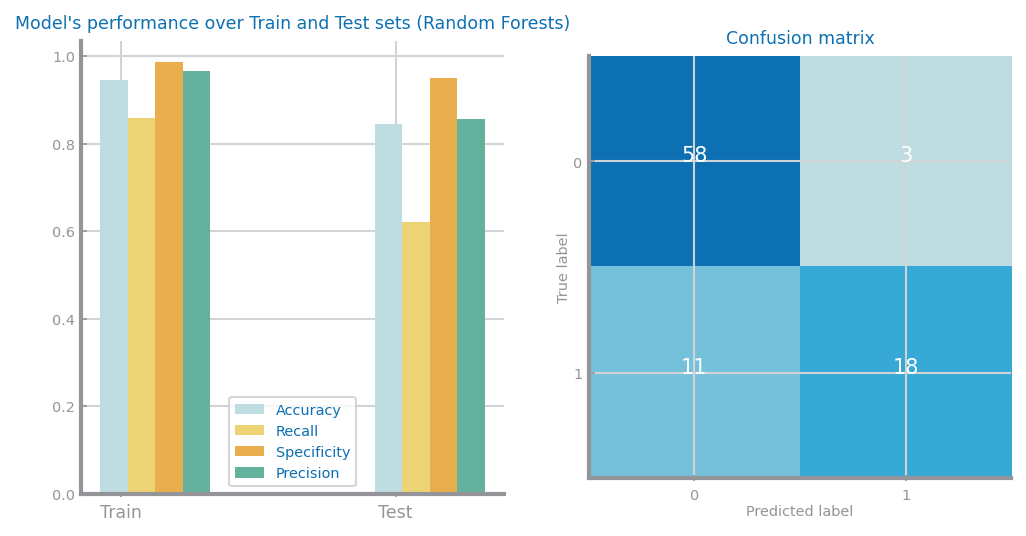

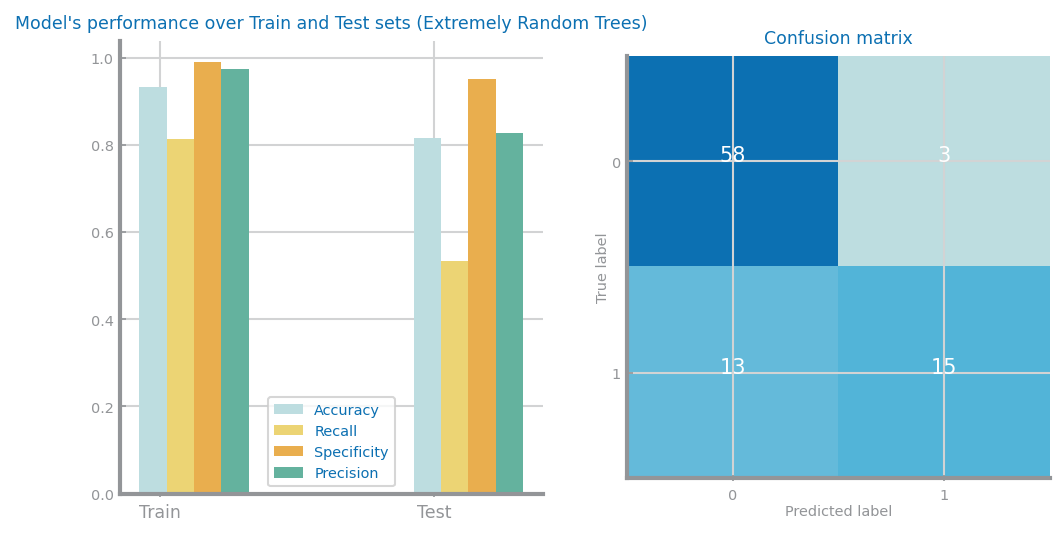

In [23]:
acc = [0, 0]
recall = [0, 0]
specificity = [0, 0]
precision = [0, 0]
matrices = np.zeros((2, 2, n_holdouts))

for h in range(n_holdouts):
    trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

    rf = ExtraTreesClassifier(n_estimators=best_extr_tree[2], max_depth=best_extr_tree[0], max_features=best_extr_tree[1])
    rf.fit(trnX, trnY)
    
    prd_trn = rf.predict(trnX)
    prd_tst = rf.predict(tstX)
    
    cnf_mtx_trn = metrics.confusion_matrix(trnY, prd_trn, labels)
    tn_trn, fp_trn, fn_trn, tp_trn = cnf_mtx_trn.ravel()
    cnf_mtx_tst = metrics.confusion_matrix(tstY, prd_tst, labels)
    matrices[:,:,h] = cnf_mtx_tst
    tn_tst, fp_tst, fn_tst, tp_tst = cnf_mtx_tst.ravel()
    
    acc[0] += (tn_trn + tp_trn) / (tn_trn + tp_trn + fp_trn + fn_trn)
    acc[1] += (tn_tst + tp_tst) / (tn_tst + tp_tst + fp_tst + fn_tst)
    
    recall[0] += tp_trn / (tp_trn + fn_trn)
    recall[1] += tp_tst / (tp_tst + fn_tst)
    
    specificity[0] += tn_trn / (tn_trn + fp_trn)
    specificity[1] += tn_tst / (tn_tst + fp_tst)
    
    precision[0] += tp_trn / (tp_trn + fp_trn)
    precision[1] += tp_tst / (tp_tst + fp_tst)
    

acc = np.divide(acc, n_holdouts)
recall = np.divide(recall, n_holdouts)
specificity = np.divide(specificity, n_holdouts)
precision = np.divide(precision, n_holdouts)
cnf_mtx = np.mean(matrices, axis=2).astype('int64')

evaluation = {'Accuracy': acc,
              'Recall': recall,
              'Specificity': specificity,
              'Precision': precision}

fig, axs = plt.subplots(1, 2, figsize=(2 * ds.HEIGHT, ds.HEIGHT))
ds.multiple_bar_chart(['Train', 'Test'], evaluation_rt, ax=axs[0], title="Model's performance over Train and Test sets (Random Forests)")
ds.plot_confusion_matrix(cnf_mtx_rt, labels, ax=axs[1])

print("Random Forests:\n", evaluation_rt)

fig, axs = plt.subplots(1, 2, figsize=(2 * ds.HEIGHT, ds.HEIGHT))
ds.multiple_bar_chart(['Train', 'Test'], evaluation, ax=axs[0], title="Model's performance over Train and Test sets (Extremely Random Trees)")
ds.plot_confusion_matrix(cnf_mtx, labels, ax=axs[1])

print("\nExtremely Random Trees:\n", evaluation)

<br/>
<br/>
<br/>
<br/>
<br/>

## Scaled & Outliers with Windsorization

### Random Forests

In [3]:
data: pd.DataFrame = pd.read_csv('../../datasets/hf_outliers/HR_S_outlierWins.csv')
y: np.ndarray = data.pop('DEATH_EVENT').values
X: np.ndarray = data.values
labels = pd.unique(y)
labels = pd.unique(y)
if(labels[0] == 1):
    temp = labels[0]
    labels[0] = labels[1]
    labels[1] = temp

<Figure size 600x450 with 0 Axes>

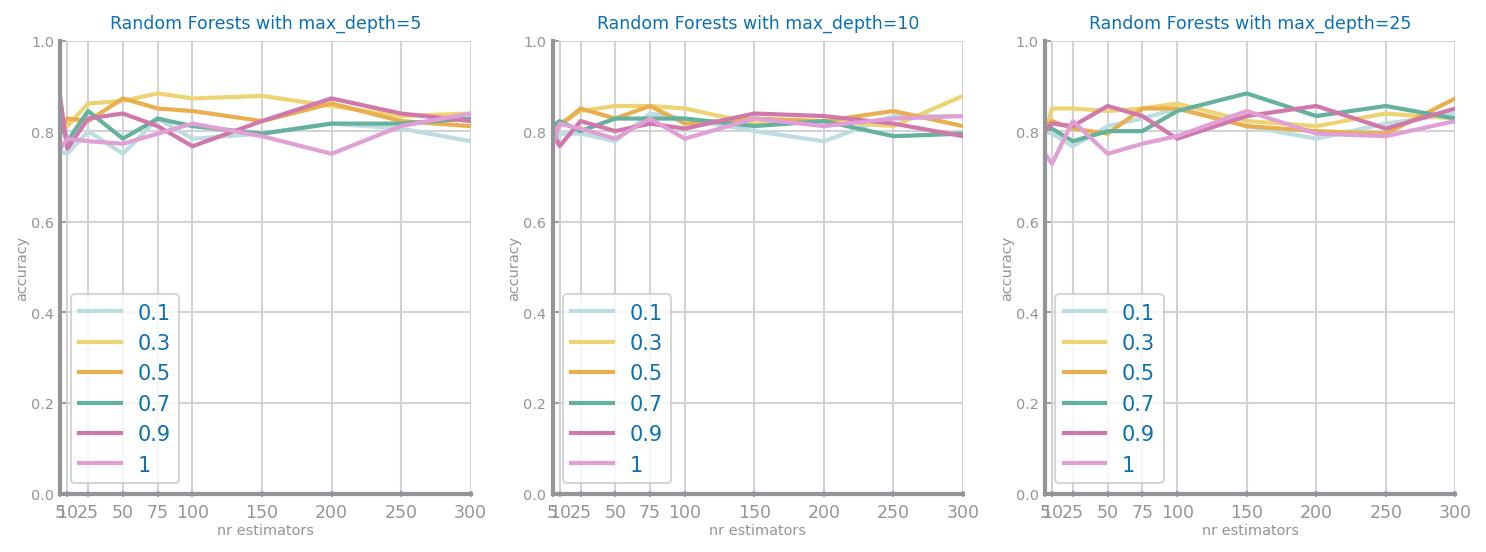

Best results with depth=5, 0.30 features and 75 estimators, with accuracy=0.88


In [3]:
n_estimators = [5, 10, 25, 50, 75, 100, 150, 200, 250, 300]
max_depths = [5, 10, 25]
max_features = [.1, .3, .5, .7, .9, 1]
best_rand_forest = ('', 0, 0)
last_best_rf = 0
best_rf = None
n_holdouts = 2

cols = len(max_depths)
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    for f in max_features:
        yvalues = []
        for n in n_estimators:
            
            total_acc = 0
            
            for h in range(n_holdouts):
                trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

                rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)
                rf.fit(trnX, trnY)
                prdY = rf.predict(tstX)
                total_acc += metrics.accuracy_score(tstY, prdY)

            total_acc /= n_holdouts
            yvalues.append(total_acc)
            if yvalues[-1] > last_best_rf:
                best_rand_forest = (d, f, n)
                last_best_rf = yvalues[-1]
                best_rf = rf
                
        values[f] = yvalues
    ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title='Random Forests with max_depth=%d'%d,
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)

plt.show()
print('Best results with depth=%d, %1.2f features and %d estimators, with accuracy=%1.2f'%(best_rand_forest[0], best_rand_forest[1], best_rand_forest[2], last_best_rf))

### Extremely Randomized Trees

In extremely randomized trees, randomness goes one step further in the way splits are computed. As in random forests, a random subset of candidate features is used, but instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias.

<Figure size 600x450 with 0 Axes>

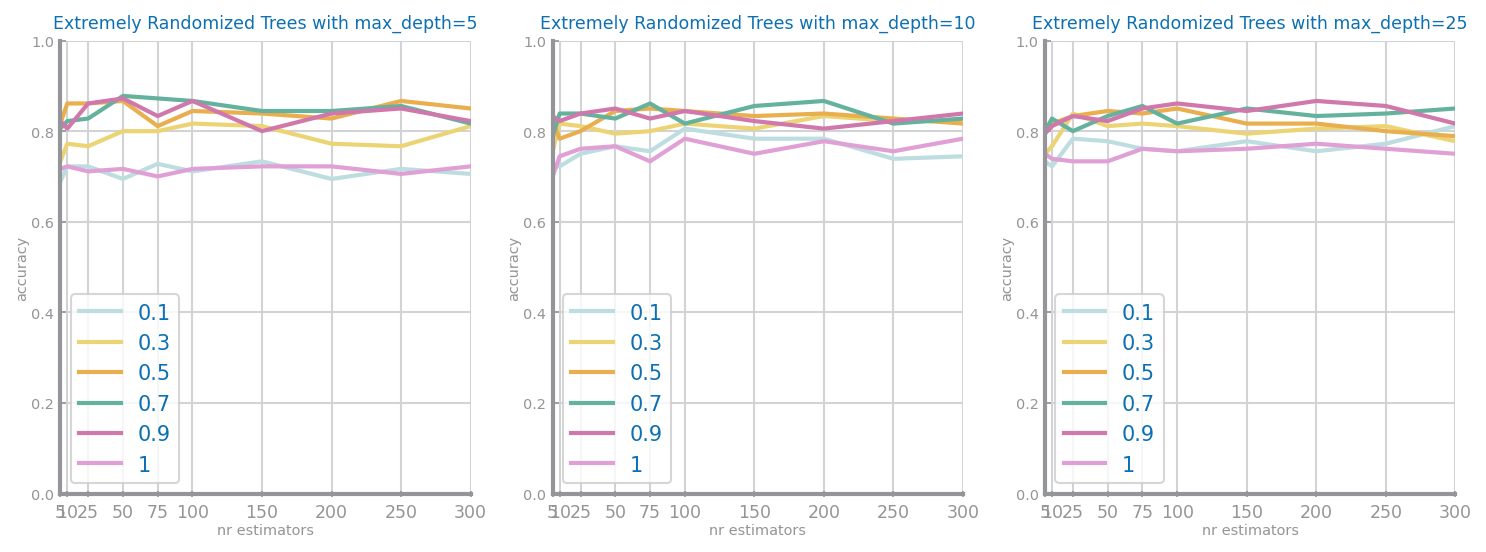

Best results with depth=5, 0.70 features and 50 estimators, with accuracy=0.88


In [4]:
best_extr_tree = ('', 0, 0)
last_best_xt = 0
best_xt = None

cols = len(max_depths)
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    for f in max_features:
        yvalues = []
        for n in n_estimators:
            
            total_acc = 0
            
            for h in range(n_holdouts):
                trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

                rf = ExtraTreesClassifier(n_estimators=n, max_depth=d, max_features=f)
                rf.fit(trnX, trnY)
                prdY = rf.predict(tstX)
                total_acc += metrics.accuracy_score(tstY, prdY)

            total_acc /= n_holdouts
            yvalues.append(total_acc)
            if yvalues[-1] > last_best_xt:
                best_extr_tree = (d, f, n)
                last_best_xt = yvalues[-1]
                best_xt = rf
                
        values[f] = yvalues
    ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title='Extremely Randomized Trees with max_depth=%d'%d,
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)

plt.show()
print('Best results with depth=%d, %1.2f features and %d estimators, with accuracy=%1.2f'%(best_extr_tree[0], best_extr_tree[1], best_extr_tree[2], last_best_xt))

### Comparing Results

In [17]:
# Compute Average Metrics for Best Random Forest vs. Best Extremely Random Trees

acc = [0, 0]
recall = [0, 0]
specificity = [0, 0]
precision = [0, 0]
matrices = np.zeros((2, 2, n_holdouts))

for h in range(n_holdouts):
    trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

    rf = RandomForestClassifier(n_estimators=best_rand_forest[2], max_depth=best_rand_forest[0], max_features=best_rand_forest[1])
    rf.fit(trnX, trnY)
    
    prd_trn = rf.predict(trnX)
    prd_tst = rf.predict(tstX)
    
    cnf_mtx_trn = metrics.confusion_matrix(trnY, prd_trn, labels)
    tn_trn, fp_trn, fn_trn, tp_trn = cnf_mtx_trn.ravel()
    cnf_mtx_tst = metrics.confusion_matrix(tstY, prd_tst, labels)
    matrices[:,:,h] = cnf_mtx_tst
    tn_tst, fp_tst, fn_tst, tp_tst = cnf_mtx_tst.ravel()
    
    acc[0] += (tn_trn + tp_trn) / (tn_trn + tp_trn + fp_trn + fn_trn)
    acc[1] += (tn_tst + tp_tst) / (tn_tst + tp_tst + fp_tst + fn_tst)
    
    recall[0] += tp_trn / (tp_trn + fn_trn)
    recall[1] += tp_tst / (tp_tst + fn_tst)
    
    specificity[0] += tn_trn / (tn_trn + fp_trn)
    specificity[1] += tn_tst / (tn_tst + fp_tst)
    
    precision[0] += tp_trn / (tp_trn + fp_trn)
    precision[1] += tp_tst / (tp_tst + fp_tst)
    

acc = np.divide(acc, n_holdouts)
recall = np.divide(recall, n_holdouts)
specificity = np.divide(specificity, n_holdouts)
precision = np.divide(precision, n_holdouts)
cnf_mtx_rt = np.mean(matrices, axis=2).astype('int64')

evaluation_rt = {'Accuracy': acc,
              'Recall': recall,
              'Specificity': specificity,
              'Precision': precision}

Random Forests:
 {'Accuracy': array([0.94, 0.84]), 'Recall': array([0.86, 0.62]), 'Specificity': array([0.99, 0.95]), 'Precision': array([0.97, 0.86])}

Extremely Random Trees:
 {'Accuracy': array([0.93, 0.82]), 'Recall': array([0.81, 0.53]), 'Specificity': array([0.99, 0.95]), 'Precision': array([0.97, 0.83])}


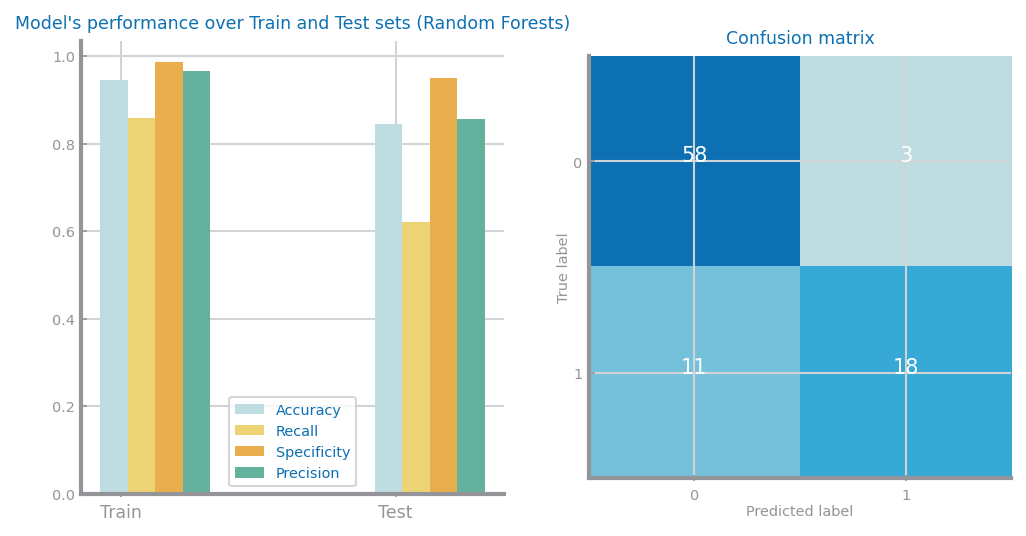

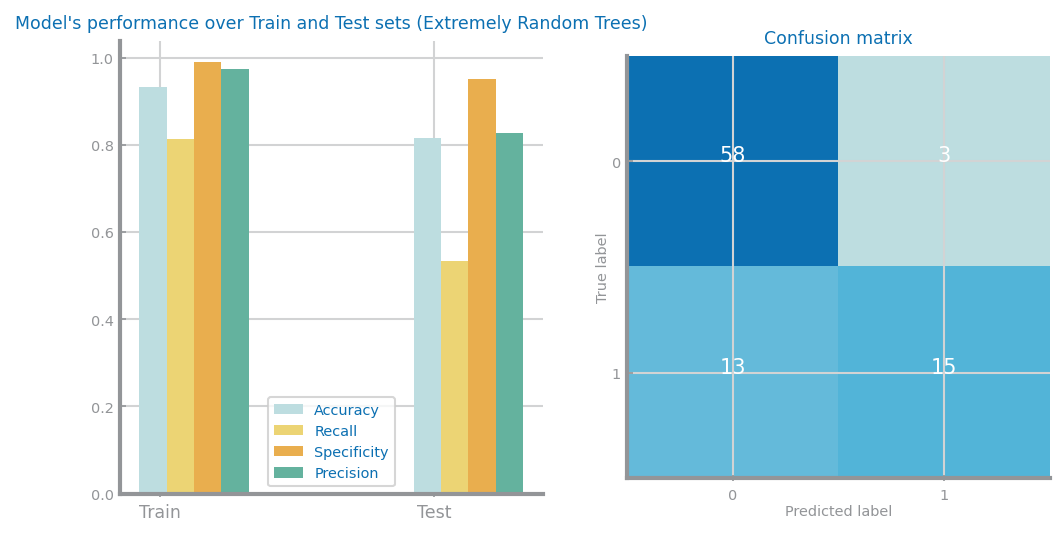

In [23]:
acc = [0, 0]
recall = [0, 0]
specificity = [0, 0]
precision = [0, 0]
matrices = np.zeros((2, 2, n_holdouts))

for h in range(n_holdouts):
    trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

    rf = ExtraTreesClassifier(n_estimators=best_extr_tree[2], max_depth=best_extr_tree[0], max_features=best_extr_tree[1])
    rf.fit(trnX, trnY)
    
    prd_trn = rf.predict(trnX)
    prd_tst = rf.predict(tstX)
    
    cnf_mtx_trn = metrics.confusion_matrix(trnY, prd_trn, labels)
    tn_trn, fp_trn, fn_trn, tp_trn = cnf_mtx_trn.ravel()
    cnf_mtx_tst = metrics.confusion_matrix(tstY, prd_tst, labels)
    matrices[:,:,h] = cnf_mtx_tst
    tn_tst, fp_tst, fn_tst, tp_tst = cnf_mtx_tst.ravel()
    
    acc[0] += (tn_trn + tp_trn) / (tn_trn + tp_trn + fp_trn + fn_trn)
    acc[1] += (tn_tst + tp_tst) / (tn_tst + tp_tst + fp_tst + fn_tst)
    
    recall[0] += tp_trn / (tp_trn + fn_trn)
    recall[1] += tp_tst / (tp_tst + fn_tst)
    
    specificity[0] += tn_trn / (tn_trn + fp_trn)
    specificity[1] += tn_tst / (tn_tst + fp_tst)
    
    precision[0] += tp_trn / (tp_trn + fp_trn)
    precision[1] += tp_tst / (tp_tst + fp_tst)
    

acc = np.divide(acc, n_holdouts)
recall = np.divide(recall, n_holdouts)
specificity = np.divide(specificity, n_holdouts)
precision = np.divide(precision, n_holdouts)
cnf_mtx = np.mean(matrices, axis=2).astype('int64')

evaluation = {'Accuracy': acc,
              'Recall': recall,
              'Specificity': specificity,
              'Precision': precision}

fig, axs = plt.subplots(1, 2, figsize=(2 * ds.HEIGHT, ds.HEIGHT))
ds.multiple_bar_chart(['Train', 'Test'], evaluation_rt, ax=axs[0], title="Model's performance over Train and Test sets (Random Forests)")
ds.plot_confusion_matrix(cnf_mtx_rt, labels, ax=axs[1])

print("Random Forests:\n", evaluation_rt)

fig, axs = plt.subplots(1, 2, figsize=(2 * ds.HEIGHT, ds.HEIGHT))
ds.multiple_bar_chart(['Train', 'Test'], evaluation, ax=axs[0], title="Model's performance over Train and Test sets (Extremely Random Trees)")
ds.plot_confusion_matrix(cnf_mtx, labels, ax=axs[1])

print("\nExtremely Random Trees:\n", evaluation)

<br/>
<br/>
<br/>
<br/>
<br/>

## Trimmed Outliers Dataset (Interquartile)

### Random Forests

In [2]:
data: pd.DataFrame = pd.read_csv('../../datasets/hf_outliers/HR_S_outlierTrim_IQS.csv')
y: np.ndarray = data.pop('DEATH_EVENT').values
X: np.ndarray = data.values
labels = pd.unique(y)
labels = pd.unique(y)
if(labels[0] == 1):
    temp = labels[0]
    labels[0] = labels[1]
    labels[1] = temp

<Figure size 600x450 with 0 Axes>

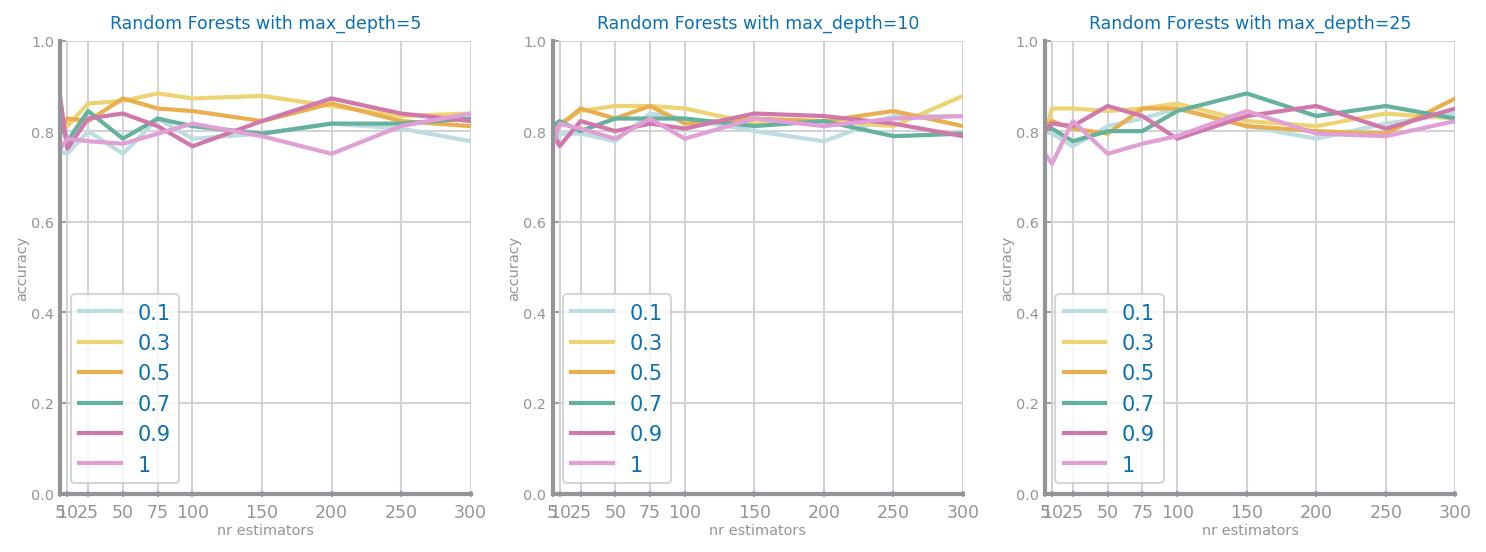

Best results with depth=5, 0.30 features and 75 estimators, with accuracy=0.88


In [3]:
n_estimators = [5, 10, 25, 50, 75, 100, 150, 200, 250, 300]
max_depths = [5, 10, 25]
max_features = [.1, .3, .5, .7, .9, 1]
best_rand_forest = ('', 0, 0)
last_best_rf = 0
best_rf = None
n_holdouts = 2

cols = len(max_depths)
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    for f in max_features:
        yvalues = []
        for n in n_estimators:
            
            total_acc = 0
            
            for h in range(n_holdouts):
                trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

                rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)
                rf.fit(trnX, trnY)
                prdY = rf.predict(tstX)
                total_acc += metrics.accuracy_score(tstY, prdY)

            total_acc /= n_holdouts
            yvalues.append(total_acc)
            if yvalues[-1] > last_best_rf:
                best_rand_forest = (d, f, n)
                last_best_rf = yvalues[-1]
                best_rf = rf
                
        values[f] = yvalues
    ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title='Random Forests with max_depth=%d'%d,
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)

plt.show()
print('Best results with depth=%d, %1.2f features and %d estimators, with accuracy=%1.2f'%(best_rand_forest[0], best_rand_forest[1], best_rand_forest[2], last_best_rf))

### Extremely Randomized Trees

In extremely randomized trees, randomness goes one step further in the way splits are computed. As in random forests, a random subset of candidate features is used, but instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias.

<Figure size 600x450 with 0 Axes>

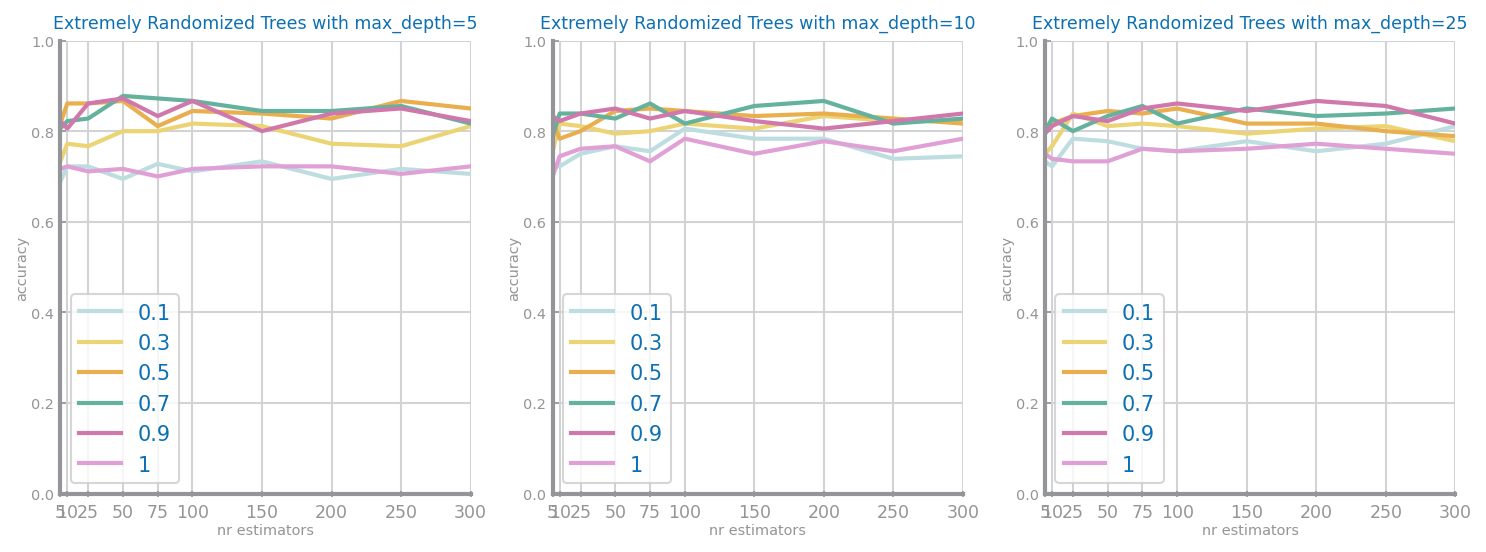

Best results with depth=5, 0.70 features and 50 estimators, with accuracy=0.88


In [4]:
best_extr_tree = ('', 0, 0)
last_best_xt = 0
best_xt = None

cols = len(max_depths)
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    for f in max_features:
        yvalues = []
        for n in n_estimators:
            
            total_acc = 0
            
            for h in range(n_holdouts):
                trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

                rf = ExtraTreesClassifier(n_estimators=n, max_depth=d, max_features=f)
                rf.fit(trnX, trnY)
                prdY = rf.predict(tstX)
                total_acc += metrics.accuracy_score(tstY, prdY)

            total_acc /= n_holdouts
            yvalues.append(total_acc)
            if yvalues[-1] > last_best_xt:
                best_extr_tree = (d, f, n)
                last_best_xt = yvalues[-1]
                best_xt = rf
                
        values[f] = yvalues
    ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title='Extremely Randomized Trees with max_depth=%d'%d,
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)

plt.show()
print('Best results with depth=%d, %1.2f features and %d estimators, with accuracy=%1.2f'%(best_extr_tree[0], best_extr_tree[1], best_extr_tree[2], last_best_xt))

### Comparing Results

In [17]:
# Compute Average Metrics for Best Random Forest vs. Best Extremely Random Trees

acc = [0, 0]
recall = [0, 0]
specificity = [0, 0]
precision = [0, 0]
matrices = np.zeros((2, 2, n_holdouts))

for h in range(n_holdouts):
    trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

    rf = RandomForestClassifier(n_estimators=best_rand_forest[2], max_depth=best_rand_forest[0], max_features=best_rand_forest[1])
    rf.fit(trnX, trnY)
    
    prd_trn = rf.predict(trnX)
    prd_tst = rf.predict(tstX)
    
    cnf_mtx_trn = metrics.confusion_matrix(trnY, prd_trn, labels)
    tn_trn, fp_trn, fn_trn, tp_trn = cnf_mtx_trn.ravel()
    cnf_mtx_tst = metrics.confusion_matrix(tstY, prd_tst, labels)
    matrices[:,:,h] = cnf_mtx_tst
    tn_tst, fp_tst, fn_tst, tp_tst = cnf_mtx_tst.ravel()
    
    acc[0] += (tn_trn + tp_trn) / (tn_trn + tp_trn + fp_trn + fn_trn)
    acc[1] += (tn_tst + tp_tst) / (tn_tst + tp_tst + fp_tst + fn_tst)
    
    recall[0] += tp_trn / (tp_trn + fn_trn)
    recall[1] += tp_tst / (tp_tst + fn_tst)
    
    specificity[0] += tn_trn / (tn_trn + fp_trn)
    specificity[1] += tn_tst / (tn_tst + fp_tst)
    
    precision[0] += tp_trn / (tp_trn + fp_trn)
    precision[1] += tp_tst / (tp_tst + fp_tst)
    

acc = np.divide(acc, n_holdouts)
recall = np.divide(recall, n_holdouts)
specificity = np.divide(specificity, n_holdouts)
precision = np.divide(precision, n_holdouts)
cnf_mtx_rt = np.mean(matrices, axis=2).astype('int64')

evaluation_rt = {'Accuracy': acc,
              'Recall': recall,
              'Specificity': specificity,
              'Precision': precision}

Random Forests:
 {'Accuracy': array([0.94, 0.84]), 'Recall': array([0.86, 0.62]), 'Specificity': array([0.99, 0.95]), 'Precision': array([0.97, 0.86])}

Extremely Random Trees:
 {'Accuracy': array([0.93, 0.82]), 'Recall': array([0.81, 0.53]), 'Specificity': array([0.99, 0.95]), 'Precision': array([0.97, 0.83])}


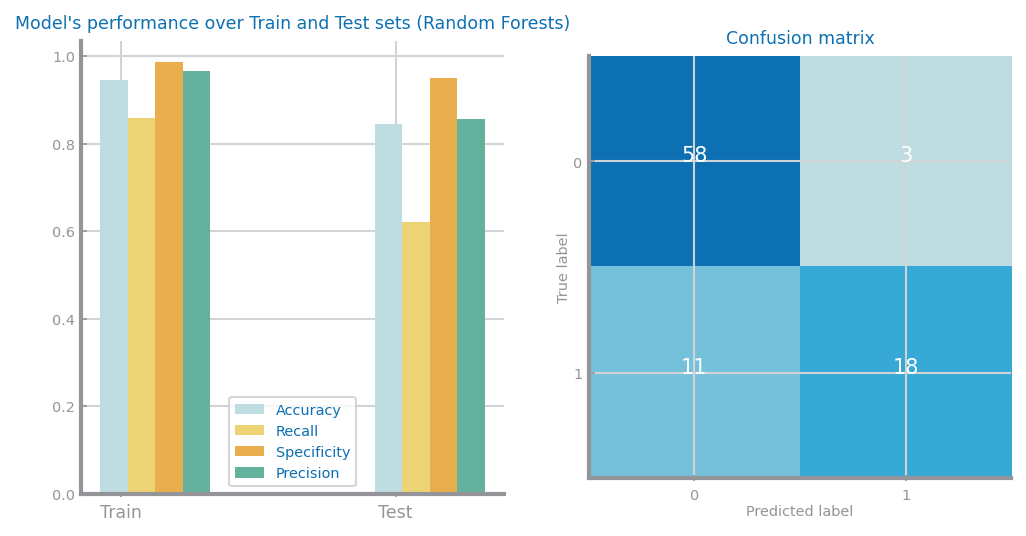

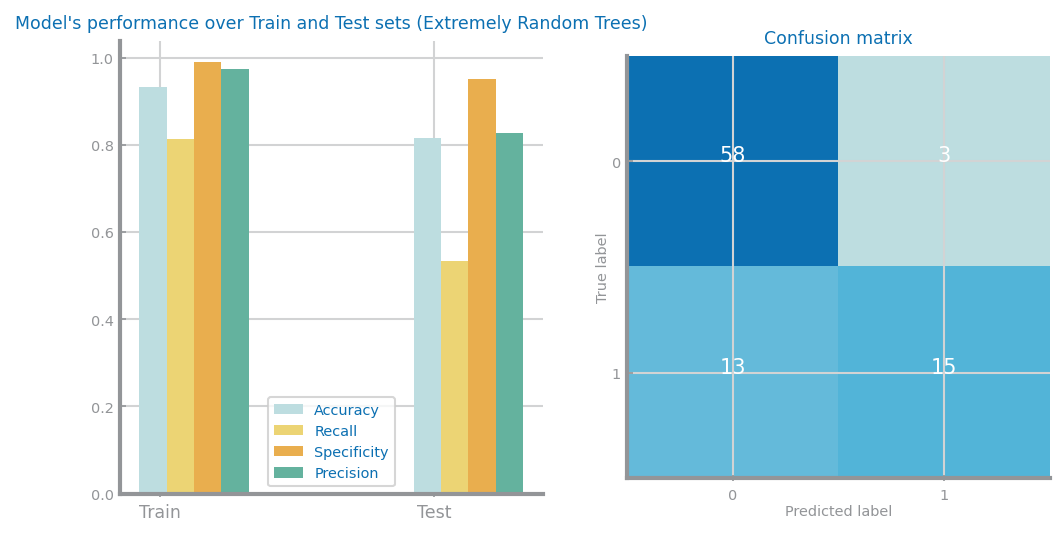

In [23]:
acc = [0, 0]
recall = [0, 0]
specificity = [0, 0]
precision = [0, 0]
matrices = np.zeros((2, 2, n_holdouts))

for h in range(n_holdouts):
    trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

    rf = ExtraTreesClassifier(n_estimators=best_extr_tree[2], max_depth=best_extr_tree[0], max_features=best_extr_tree[1])
    rf.fit(trnX, trnY)
    
    prd_trn = rf.predict(trnX)
    prd_tst = rf.predict(tstX)
    
    cnf_mtx_trn = metrics.confusion_matrix(trnY, prd_trn, labels)
    tn_trn, fp_trn, fn_trn, tp_trn = cnf_mtx_trn.ravel()
    cnf_mtx_tst = metrics.confusion_matrix(tstY, prd_tst, labels)
    matrices[:,:,h] = cnf_mtx_tst
    tn_tst, fp_tst, fn_tst, tp_tst = cnf_mtx_tst.ravel()
    
    acc[0] += (tn_trn + tp_trn) / (tn_trn + tp_trn + fp_trn + fn_trn)
    acc[1] += (tn_tst + tp_tst) / (tn_tst + tp_tst + fp_tst + fn_tst)
    
    recall[0] += tp_trn / (tp_trn + fn_trn)
    recall[1] += tp_tst / (tp_tst + fn_tst)
    
    specificity[0] += tn_trn / (tn_trn + fp_trn)
    specificity[1] += tn_tst / (tn_tst + fp_tst)
    
    precision[0] += tp_trn / (tp_trn + fp_trn)
    precision[1] += tp_tst / (tp_tst + fp_tst)
    

acc = np.divide(acc, n_holdouts)
recall = np.divide(recall, n_holdouts)
specificity = np.divide(specificity, n_holdouts)
precision = np.divide(precision, n_holdouts)
cnf_mtx = np.mean(matrices, axis=2).astype('int64')

evaluation = {'Accuracy': acc,
              'Recall': recall,
              'Specificity': specificity,
              'Precision': precision}

fig, axs = plt.subplots(1, 2, figsize=(2 * ds.HEIGHT, ds.HEIGHT))
ds.multiple_bar_chart(['Train', 'Test'], evaluation_rt, ax=axs[0], title="Model's performance over Train and Test sets (Random Forests)")
ds.plot_confusion_matrix(cnf_mtx_rt, labels, ax=axs[1])

print("Random Forests:\n", evaluation_rt)

fig, axs = plt.subplots(1, 2, figsize=(2 * ds.HEIGHT, ds.HEIGHT))
ds.multiple_bar_chart(['Train', 'Test'], evaluation, ax=axs[0], title="Model's performance over Train and Test sets (Extremely Random Trees)")
ds.plot_confusion_matrix(cnf_mtx, labels, ax=axs[1])

print("\nExtremely Random Trees:\n", evaluation)

# Summary

* How does performance change with the number of estimators?
    * Performance does not seem to systematically improve as we increase the number of estimators, hence this fine-tuning should iterate over random values for this hyper-parameter.

* How does performance change with the number of features?
    * For Random Forests, when we include more than half the features we tend to obtain overall worse results. This difference is more noticeable in Extremely Random Trees.

* How do models improve with the increase of max_depth?
    * Overall performance seems to be slightly related to greater max_depths.

* What is the best parametrisation (max_depth, number of estimators and features)?

* Is the accuracy achieved good enough?

* What is the largest kind of errors?

* Is it possible to identify overfitting?

* How does feature selection impacts the results?